In [1]:
%reset -f

In [2]:
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# import plottools
# import torch                      #PyTorch
# import torch.nn as nn             #PyTorch module for neural nets
# from torch.autograd import grad   #For taking derivatives

from IPython.display import clear_output
# import sys

from scipy.optimize import fsolve
# from scipy.sparse import spdiags

import scipy.sparse as sp
# Plot Tools

# import itertools as iter
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

import warnings
warnings.simplefilter('ignore')

import ray

import pyvista as pv
from pyvista.utilities import lines_from_points
# from itkwidgets import view

In [3]:
class Manifold:

    def __init__(self, w_a1, w_a2, w_1, w_2, alpha, beta, theta):

        self.w_1 = w_1
        self.w_2 = w_2

        self.w_a1 = w_a1
        self.w_a2 = w_a2
        self.w_b1 = w_1 - w_a1
        self.w_b2 = w_2 - w_a2
        self.alpha = alpha
        self.beta = beta
        self.theta = theta
    
    def excess(self, plot):

        p_bar = np.linspace(1E-7, 5, 50000)
        len = p_bar.__len__()
        
        z_1 = (1/p_bar)*self.w_a2 - (1/p_bar)*(self.alpha - 1/p_bar) + self.theta*(self.beta - p_bar) - self.w_b1
        z_2 = self.alpha - 1/p_bar + p_bar*self.w_b1 - self.theta*p_bar*(self.beta - p_bar) - self.w_a2

        z = z_1
        opp = z[0:len-1] * z[1:len]

        if plot == True:
            plt.plot(p_bar, z, color ='k', alpha = 0.1)
        
        self.i0 = p_bar[0:len-1][(opp < 0)]
        self.i0_len = self.i0.__len__()
        # return p_bar[0:len-1][(opp < 0)]
    
    def SolveP(self, i0):
        
        def z_fun(x):
            fn = (1/x)*self.w_a2 - (1/x)*(self.alpha - 1/x) + self.theta*(self.beta - x) - self.w_b1 # z_1
            # fn = self.alpha - 1/x + x*self.w_b1 - self.theta*x*(self.beta - x) - self.w_a2 # z_2

            return fn
    
        p_solved = fsolve(z_fun, i0)

        fcheck = 0
        if np.isclose(z_fun(p_solved), 0) == False:
            fcheck = 1

        return [self.w_a1, self.w_a2, p_solved[0], fcheck]

In [4]:
class GetResult:

    def __init__(self, alpha, beta, theta, surf = True):
        
        self.alpha = alpha
        self.beta = beta
        self.theta = theta

        self.w_1 = 20
        self.w_2 = 20
        # self.Grid_1 = np.linspace(1E-7, self.w_1-1E-7,200)
        # self.Grid_2 = np.linspace(1E-7, self.w_2-1E-7,400)
        begin = 0.99
        if surf == False:
            begin = 1E-7
        self.Grid_1 = np.concatenate((np.linspace(begin, 10, 50), np.linspace(10, self.w_1 - begin, 200))) # for x_{a1}
        self.Grid_2 = np.concatenate((np.linspace(begin, 5, 200), np.linspace(5, self.w_2 - begin, 50))) # for x_{a2}

    def ManifoldResult(self):

        Result = []
        for gg1 in self.Grid_1:
            for gg2 in self.Grid_2:

                MF = Manifold(gg1, gg2, self.w_1, self.w_2, self.alpha, self.beta, self.theta)
                MF.excess(False)

                for ii in range(MF.i0_len):
                    subResult = MF.SolveP(MF.i0[ii])
                    subResult.append(ii)
                    Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]
        self.Result = Result

    def GetContract(self):

        w_a1, w_a2, p_bar = self.Result[:,[0]], self.Result[:,[1]], self.Result[:,[2]]
        
        x_a1 = w_a1 + 1/p_bar * w_a2 - 1/p_bar*(self.alpha - 1/p_bar)
        x_a2 = self.alpha - 1/p_bar
        
        Contract = np.hstack([w_a1, w_a2, x_a1, x_a2])
        Contract = Contract[np.where(Contract[:,2] * Contract[:,3] > 0)]
        Contract = Contract[np.where(Contract[:,2] < w_a1.max())]
        Contract = Contract[np.where(Contract[:,3] < w_a2.max())]
        
        E_contract = np.sort(Contract, 0)
        self.E_contract = E_contract
    
    def NonTrade(self):

        Result = []

        for ii in range(self.E_contract.__len__()):

            w_a1 = self.E_contract[ii,2]
            w_a2 = self.E_contract[ii,3]

            MF = Manifold(w_a1, w_a2, self.w_1, self.w_2, self.alpha, self.beta, self.theta)
            MF.excess(False)

            for jj in range(MF.i0_len):
                subResult = MF.SolveP(MF.i0[jj])
                subResult.append(0)
                Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]
        self.NonTradeSet = Result

    def MF_grid(self):
        self.MF_grid = self.Result[(self.Result[:,4] > 0)]
        

In [5]:
Man_baseline = GetResult(alpha=10, beta=2, theta=10)
Man_baseline.ManifoldResult()
Man_baseline.GetContract()
Man_baseline.NonTrade()
Man_baseline.MF_grid()

Reconstruct Surface

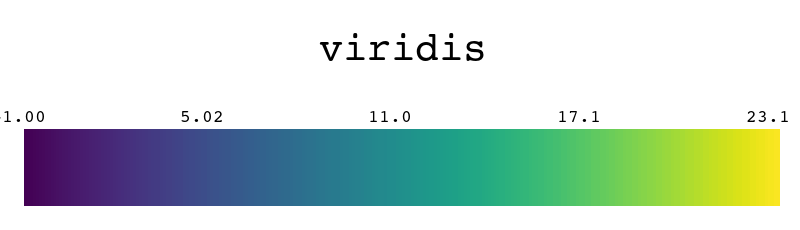

In [6]:
p_inf = 10

point = Man_baseline.Result[:,0:3]
point[:,2] = point[:,2]*p_inf

cloud = pv.PolyData(point)

surf = cloud.reconstruct_surface()
surf = surf.extract_surface()
surf['Data'] = surf.points[:,[2]]
surf.save('Q_example.stl')

point_notrade = Man_baseline.NonTradeSet[:,0:3]
point_notrade[:,2] = point_notrade[:,2]*p_inf
spline = pv.Spline(point_notrade, 200)

z_trunk = point[:,2].max()
pv.global_theme.font.size = 20
pv.global_theme.font.family = 'courier'
lut = pv.LookupTable()
lut.cmap = 'viridis'
lut.scalar_range = (-1, z_trunk)
lut.plot()

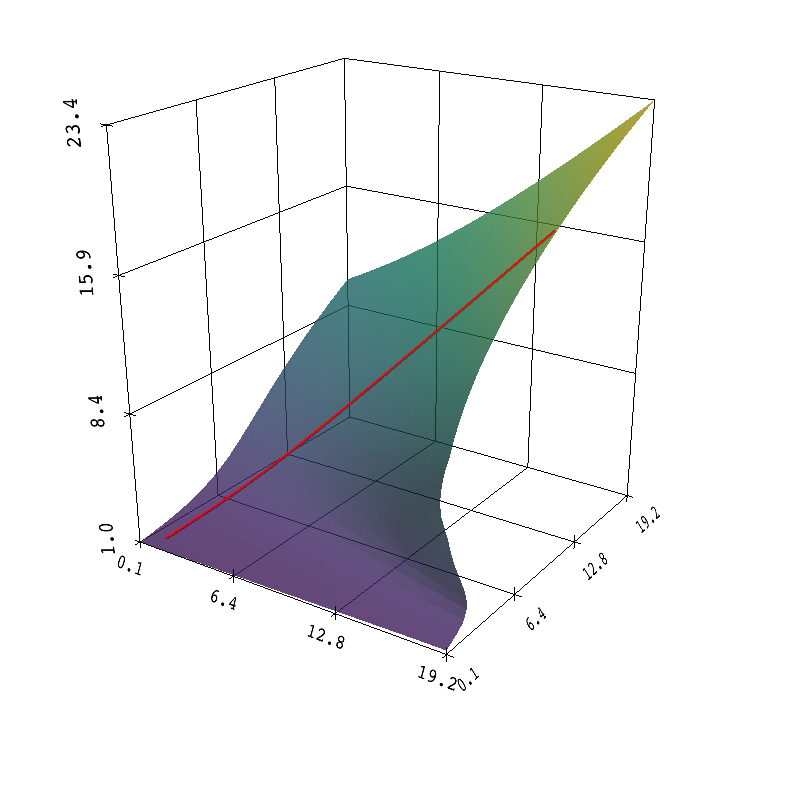

In [7]:
p = pv.Plotter(window_size=[800, 800])
p.add_mesh(surf, cmap=lut, show_scalar_bar=False, show_edges=False, interpolate_before_map=True, opacity=0.8, lighting=True)
p.add_mesh(spline, line_width=3, color='red')
p.show_grid(bold = False, n_xlabels=4, n_ylabels=4, n_zlabels=4, xtitle='', ytitle='', ztitle='')
p.camera_position = [(50,-50,40),(10,10,8),(0, 0, 1)]
# p.camera.zoom(1)
p.show()
p.save_graphic('Manifold_Q.pdf')

In [8]:
Man1 = Man_baseline.Result[(Man_baseline.Result[:,4] == 0)]
Man2 = Man_baseline.Result[(Man_baseline.Result[:,4] == 1)]
Man3 = Man_baseline.Result[(Man_baseline.Result[:,4] > 1)]

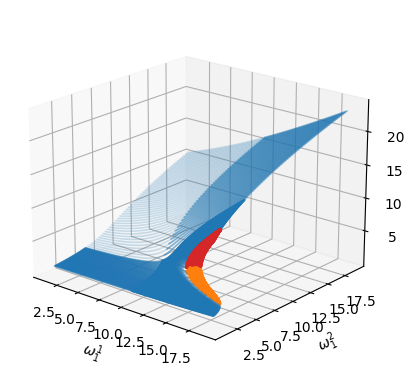

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(Man1[:,0],Man1[:,1],np.round(Man1[:,2],3), s=2,edgecolor='none',marker='o', alpha = 0.2, color = 'C0')
p = ax.scatter(Man2[:,0],Man2[:,1],np.round(Man2[:,2],3), s=3,edgecolor='none',marker='o', alpha = 1,  color = 'C1')
p = ax.scatter(Man3[:,0],Man3[:,1],np.round(Man3[:,2],3), s=6,edgecolor='none',marker='o', alpha = 1,  color = 'C3')
ax.set_xlabel(r'$\omega_1^1$')
ax.set_ylabel(r'$\omega_1^2$')
ax.view_init(elev=20., azim=310)
plt.savefig('PointCloud_Q.png', dpi=300, bbox_inches='tight')

In [10]:
Man_baseline = GetResult(alpha=10, beta=2, theta=10, surf=False)
Man_baseline.ManifoldResult()
Man_baseline.GetContract()
Man_baseline.MF_grid()

Man_r1 = GetResult(alpha=10, beta=2, theta=12, surf=False)
Man_r1.ManifoldResult()
Man_r1.GetContract()
Man_r1.MF_grid()

Man_r2 = GetResult(alpha=10, beta=2, theta=15, surf=False)
Man_r2.ManifoldResult()
Man_r2.GetContract()
Man_r2.MF_grid()

In [11]:
# function to plot the color-filled folded area
def plot_fold_edge(data, color_choice, alpha_choice):

    list1 = np.unique(data[:,0])
    maxlist1 = np.asarray([data[data[:,0] == gg][:,1].max() for gg in list1])
    maxlist2 = np.asarray([data[data[:,0] == gg][:,1].min() for gg in list1])

    # criterion
    list2 = np.unique(data[:,1])
    crit = np.asarray([data[data[:,1] == gg][:,0].min() for gg in list2]).max()
    maxlist2[list1 > crit] = 0

    # edges
    plt.plot(list1, maxlist1, linewidth = 1, color = color_choice)
    plt.plot(list1[list1 <= crit], maxlist2[list1 <= crit], linewidth = 1, color = color_choice)

    # fill colors
    plt.fill_between(list1, maxlist1, maxlist2, color = color_choice, alpha = alpha_choice)

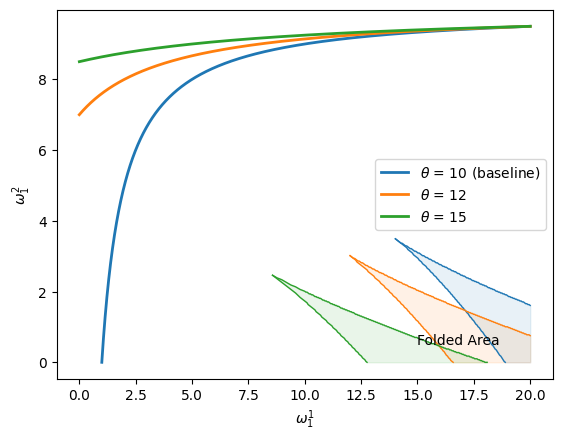

: 

In [12]:
plt.plot(Man_baseline.E_contract[:,2], Man_baseline.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C0')
plt.plot(Man_r1.E_contract[:,2], Man_r1.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C1')
plt.plot(Man_r2.E_contract[:,2], Man_r2.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C2')

plot_fold_edge(Man_baseline.MF_grid, 'C0', 0.1)
plot_fold_edge(Man_r1.MF_grid, 'C1', 0.1)
plot_fold_edge(Man_r2.MF_grid, 'C2', 0.1)

plt.annotate('Folded Area', [35,0.2])
plt.xlabel(r'$\omega_1^1$')
plt.ylabel(r'$\omega_1^2$')

plt.legend([r'$\theta$ = 10 (baseline)', r'$\theta$ = 12', r'$\theta$ = 15'])

plt.annotate('Folded Area', [15,0.5])

plt.savefig('Contract_Q.png', dpi=300, bbox_inches='tight')